In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 




import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'relative'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_roberta_about_relative'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5102040816326531
MALE 0.0
FEMALE 1.0 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.4810606060606061
MALE 0.0
FEMALE 1.0 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.48370273794002605
MALE 0.0
FEMALE 1.0 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6853448130735537 	 Validation loss: 0.6842358324487331 	 
  1%|          | 574/57400 [01:23<2:02:06,  7.76it/s]
Epoch 2 	 Training loss: 0.6822150569759595 	 Validation loss: 0.6838380512544664 	 
  2%|▏         | 1148/57400 [02:56<2:31:50,  6.17it/s]
Epoch 3 	 Training loss: 0.6815878275379487 	 Validation loss: 0.6834223219903849 	 
  3%|▎         | 1722/57400 [04:29<2:11:11,  7.07it/s]
Epoch 4 	 Training loss: 0.6805901500406165 	 Validation loss: 0.682656775086613 	 
  4%|▍         | 2296/57400 [06:03<2:28:37,  6.18it/s]
Epoch 5 	 Training loss: 0.6787984885197483 	 Validation loss: 0.680863241017875 	 
  5%|▌         | 2870/57400 [07:36<2:01:01,  7.51it/s]
Epoch 6 	 Training loss: 0.6720708745697234 	 Validation loss: 0.6618795273667675 	 
  6%|▌         | 3444/57400 [09:11<2:13:55,  6.71it/s]
Epoch 7 	 Training loss: 0.5630397209410883 	 Validation loss: 0.4534182109064975 	 
  7%|▋         | 4018/57400 [10:44<2:09:58,  6.85it/s]
Epoch 8 	 Training loss

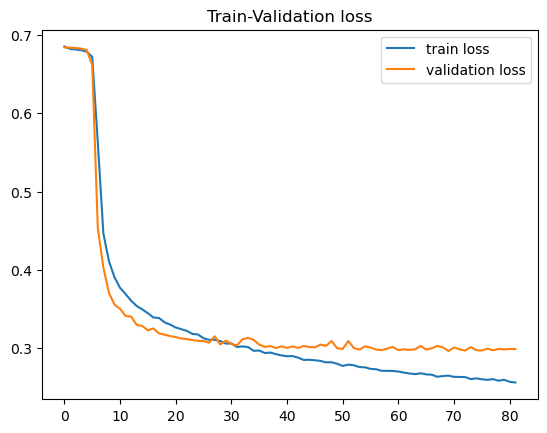

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8673469387755102
MALE 0.8802083333333334
FEMALE 0.855 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6919191919191919
MALE 0.7153284671532847
FEMALE 0.6666666666666666 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6897001303780965
MALE 0.7171717171717171
FEMALE 0.660377358490566 



# TO

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_roberta_to_relative'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6940593936509787 	 Validation loss: 0.6932959859654054 	 
  1%|          | 574/57400 [01:24<2:03:32,  7.67it/s]
Epoch 2 	 Training loss: 0.6933001543586678 	 Validation loss: 0.6925093895297939 	 
  2%|▏         | 1148/57400 [02:49<2:08:10,  7.31it/s]
Epoch 3 	 Training loss: 0.6933560276903757 	 Validation loss: 0.6932086671813059 	 
  3%|▎         | 1722/57400 [04:14<2:10:13,  7.13it/s]
Epoch 4 	 Training loss: 0.6933706552309442 	 Validation loss: 0.6923152763964766 	 
  4%|▍         | 2296/57400 [05:39<2:15:33,  6.77it/s]
Epoch 5 	 Training loss: 0.6933423306676153 	 Validation loss: 0.6920552152698323 	 
  5%|▌         | 2870/57400 [07:04<2:13:55,  6.79it/s]
Epoch 6 	 Training loss: 0.6933841432220844 	 Validation loss: 0.6928095979205633 	 
  6%|▌         | 3444/57400 [08:29<2:00:43,  7.45it/s]
Epoch 7 	 Training loss: 0.6934457490876161 	 Validation loss: 0.693171757762715 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [09:54<2:09:09,  6.8

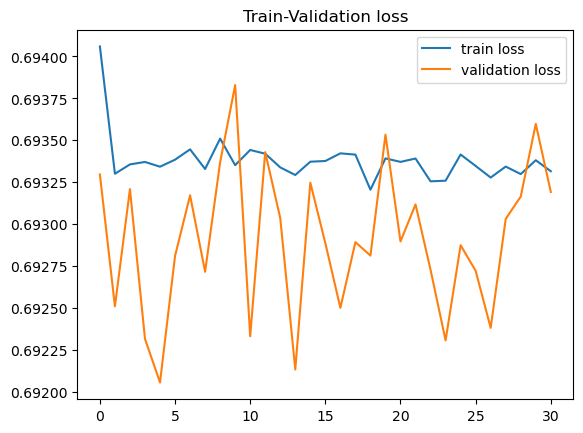

In [20]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5012755102040817
MALE 0.10416666666666667
FEMALE 0.8825 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.4861111111111111
MALE 0.09245742092457421
FEMALE 0.910761154855643 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.4954367666232073
MALE 0.10101010101010101
FEMALE 0.9164420485175202 



# AS

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_roberta_as_relative'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936916432729582 	 Validation loss: 0.693875215821347 	 
  1%|          | 574/57400 [01:24<2:07:05,  7.45it/s]
Epoch 2 	 Training loss: 0.6935937882300454 	 Validation loss: 0.6925348710205596 	 
  2%|▏         | 1148/57400 [02:49<2:15:28,  6.92it/s]
Epoch 3 	 Training loss: 0.6934748208896624 	 Validation loss: 0.691970711037264 	 
  3%|▎         | 1722/57400 [04:14<2:19:56,  6.63it/s]
Epoch 4 	 Training loss: 0.6935398261929223 	 Validation loss: 0.6922741926322549 	 
  4%|▍         | 2296/57400 [05:39<2:14:53,  6.81it/s]
Epoch 5 	 Training loss: 0.6933521132020585 	 Validation loss: 0.6937029503159604 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [07:04<2:10:53,  6.94it/s]
Epoch 6 	 Training loss: 0.6934176897338044 	 Validation loss: 0.6927226923279843 	 
  6%|▌         | 3444/57400 [08:28<2:12:57,  6.76it/s]
Epoch 7 	 Training loss: 0.6933952971825617 	 Validation loss: 0.6928925776885728 	 
  7%|▋         | 4018/57400 [09:53<2:09:57,  6.85

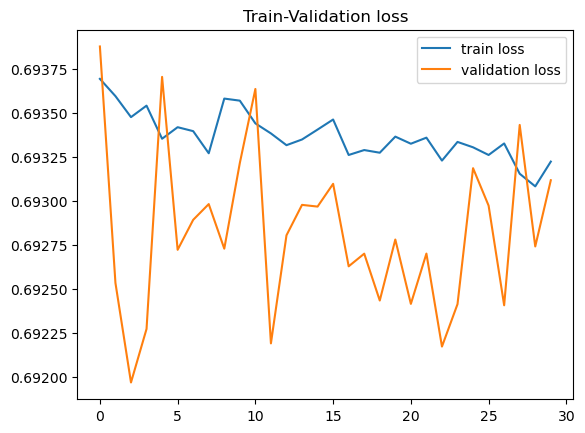

In [23]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [24]:

model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5025510204081632
MALE 0.041666666666666664
FEMALE 0.945 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.48484848484848486
MALE 0.072992700729927
FEMALE 0.9291338582677166 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.4810951760104302
MALE 0.04292929292929293
FEMALE 0.9487870619946092 

